In [1]:
import gymnasium as gym
from gymnasium import spaces
import json
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.backends.backend_agg import FigureCanvasAgg

from stable_baselines3 import A2C, PPO, DQN
from sb3_contrib import MaskablePPO
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.common.maskable.callbacks import MaskableEvalCallback

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.logger import configure
from stable_baselines3.common.env_checker import check_env

In [2]:
from scheduler_env.customEnv_repeat import SchedulingEnv

In [3]:
import warnings
# 특정 경고를 무시하도록 필터를 설정합니다.
warnings.filterwarnings("ignore", category=Warning)

In [4]:
env = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat.json", max_repeats = [5] * 12)

Goal reached! final score= 44.99572530665322
finish_time 5500
machine_operation_rate [0.8363636363636363, 0.2727272727272727, 1.0, 0.509090909090909, 0.7090909090909091, 0.6545454545454545, 0.7090909090909091, 0.5272727272727272]
job_deadline [900, 1800, 1300, 2500, 3500, 900, 1250, 1050, 1600, 1050, 1500, 2900, 2200, 3800, 900, 1400, 2700, 2000, 3600, 900, 1200, 1700, 2300, 3100, 1050, 1400, 2000, 2700, 1500, 750, 1100, 1600, 2200, 2900, 900, 2000, 1400, 2700, 1050, 1600, 3100, 2300, 4100, 1050, 1500]
job_time_exceeded [1300, 2500, 1400, 2100, 2000, 1100, 1750, 750, 1200, 550, 2300, 1100, 2800, 1600, 900, 500, 1300, 500, 0, 0, 900, 1200, 1200, 900, 1650, 1200, 1200, 1800, 0, 1150, 400, 900, 1400, 800, 300, 700, 300, 1900, 250, 500, 400, 900, 100, 150, 0]
current_repeats [5, 2, 2, 5, 5, 5, 4, 1, 5, 4, 5, 2]
3587.5


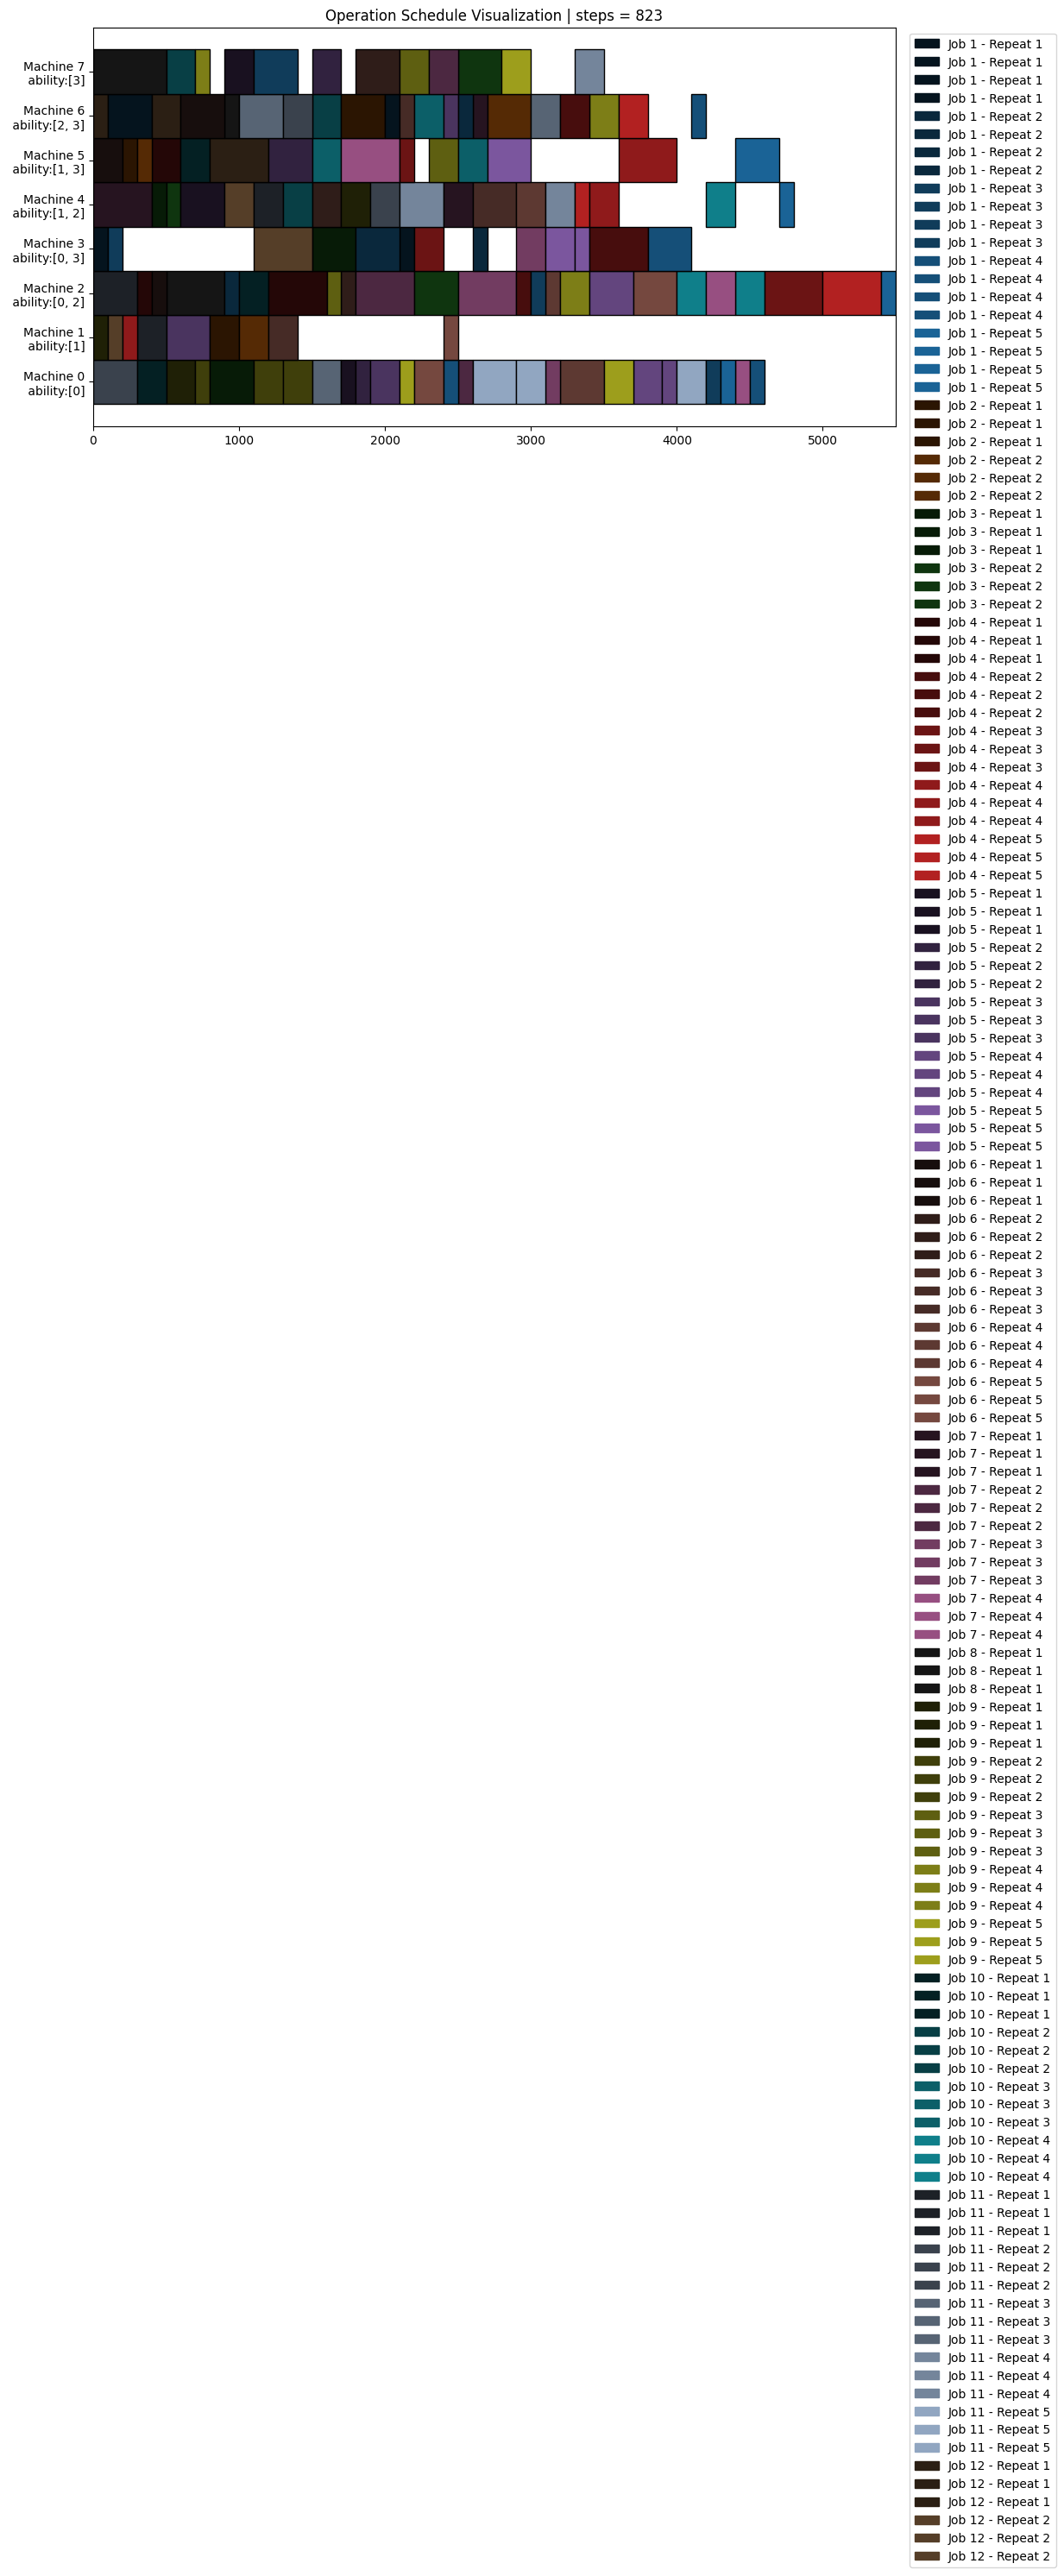

In [5]:
step = 0
obs, info = env.reset()
#print(info['schedule_buffer'])

while True:
    step += 1
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(action)
    # print(f"action : {action // 3}, {action % 3}")
    # print(info['schedule_buffer'])
    # env.visualize_graph()
    done = terminated or truncated
    
    
    if done:
        print("Goal reached!", "final score=", reward)
        print('finish_time', info['finish_time'])
        print('machine_operation_rate', info['machine_operation_rate'])
        print('job_deadline', info['job_deadline'])
        print('job_time_exceeded', info['job_time_exceeded'])
        print('current_repeats', info['current_repeats'])
        print(env.target_time)
        env.render()
        break

In [6]:
# job_paths와 machine_paths를 포함하는 목록
job_paths = ["instances/Jobs/v0-12-repeat.json"]
machine_paths = ["instances/Machines/v0-8.json"]

def make_env(job_path, machine_path, test_mode, max_repeats):
    def _init():
        env = SchedulingEnv(job_config_path=job_path, machine_config_path=machine_path, max_repeats = max_repeats, test_mode = test_mode)
        return Monitor(env)
    return _init

envs = [make_env(job_paths[0], machine_paths[0], True, [3]*12), make_env(job_paths[0], machine_paths[0], False, [5]*12)]

vec_env = SubprocVecEnv(envs)

In [7]:
log_path = "./logs/tmp/1"
# set up logger
new_logger = configure(log_path, ["stdout", "csv", "tensorboard"])

# Create the evaluation environment
eval_env = DummyVecEnv([make_env(job_paths[0], machine_paths[0], False, [5]*12)])

# Create the EvalCallback
# eval_callback = EvalCallback(eval_env, best_model_save_path=log_path,
#                              log_path=log_path, eval_freq=10000,
#                              deterministic=True, render=False)
eval_callback = MaskableEvalCallback(eval_env, best_model_save_path=log_path,
                                     log_path=log_path, eval_freq=10000,
                                     deterministic=True, render=False)

Logging to ./logs/tmp/1


In [8]:
model = MaskablePPO('MultiInputPolicy', vec_env, verbose=1)
model.set_logger(new_logger)
model.learn(1_000_000, callback=eval_callback)

Using cpu device


/Users/chiyeong/Documents/projects/winter-study-reinforcement/RL-Scheduler/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.action_masks to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_masks` for environment variables or `env.get_wrapper_attr('action_masks')` that will search the reminding wrappers.
  logger.warn(
/Users/chiyeong/Documents/projects/winter-study-reinforcement/RL-Scheduler/.venv/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.action_masks to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.action_masks` for environment variables or `env.get_wrapper_attr('action_masks')` that will search the reminding wrappers.
  logger.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 109      |
|    ep_rew_mean     | 83.1     |
| time/              |          |
|    fps             | 1610     |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 4096     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 110        |
|    ep_rew_mean          | 84.6       |
| time/                   |            |
|    fps                  | 1192       |
|    iterations           | 2          |
|    time_elapsed         | 6          |
|    total_timesteps      | 8192       |
| train/                  |            |
|    approx_kl            | 0.01407711 |
|    clip_fraction        | 0.119      |
|    clip_range           | 0.2        |
|    entropy_loss         | -3.61      |
|    explained_variance   | -0.012     |
|    learning_rate        | 0.0003     |
|   

In [9]:
env1 = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat.json", max_repeats = [3] * 12, test_mode = True)
env2 = SchedulingEnv(machine_config_path= "instances/Machines/v0-8.json", job_config_path = "instances/Jobs/v0-12-repeat.json", max_repeats = [5] * 12, test_mode = False)

custom_env = [env1, env2]

Goal reached! final score= 72.72013897780096
job_deadline [900, 1300, 1800, 900, 1250, 1800, 1050, 1600, 2300, 1050, 1500, 2200, 900, 1400, 2000, 900, 1200, 1700, 1050, 1400, 2000, 1500, 2200, 3000, 750, 1100, 1600, 900, 1400, 2000, 1050, 1600, 2300, 1050, 1500, 2100]
job_time_exceeded [400, 200, 1800, 200, 350, 100, 450, 800, 800, 1050, 1300, 1000, 400, 400, 0, 1300, 1100, 1000, 550, 900, 400, 0, 0, 0, 550, 600, 1900, 700, 500, 100, 1350, 1200, 1200, 1850, 1800, 700]
current_repeats [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
3000.0


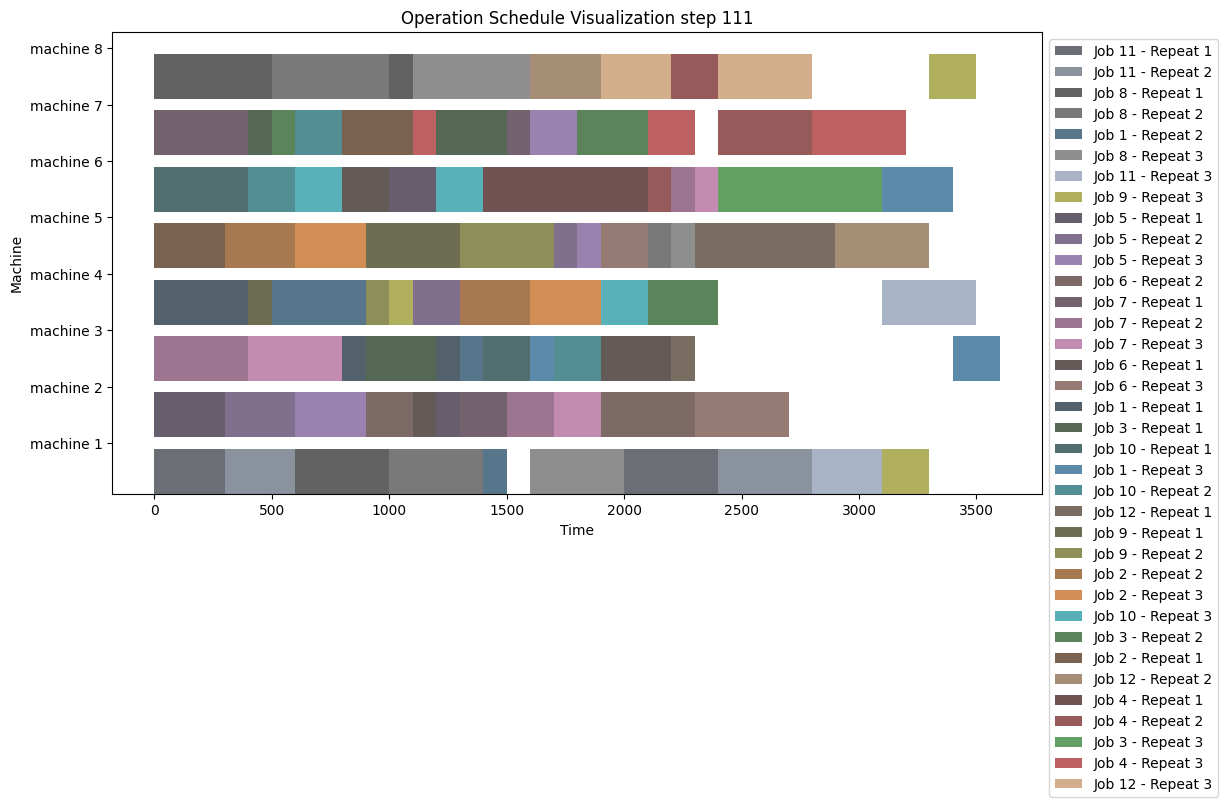

Goal reached! final score= 63.56770499731276
job_deadline [900, 1300, 1800, 2500, 3500, 900, 1050, 1050, 1500, 2200, 900, 1400, 2000, 900, 1200, 1700, 2300, 1050, 1400, 2000, 2700, 1500, 2200, 3000, 4000, 750, 900, 1400, 2000, 2700, 3600, 1050, 2300, 1600, 3100, 4100, 1050, 1500, 2100]
job_time_exceeded [1400, 800, 1500, 1300, 200, 900, 350, 1850, 1800, 1800, 300, 100, 0, 1100, 1600, 1500, 1000, 450, 500, 0, 0, 600, 200, 0, 0, 0, 100, 0, 0, 0, 0, 0, 0, 200, 0, 0, 2850, 2300, 2300]
current_repeats [5, 1, 1, 3, 3, 4, 4, 4, 1, 5, 5, 3]
3312.5


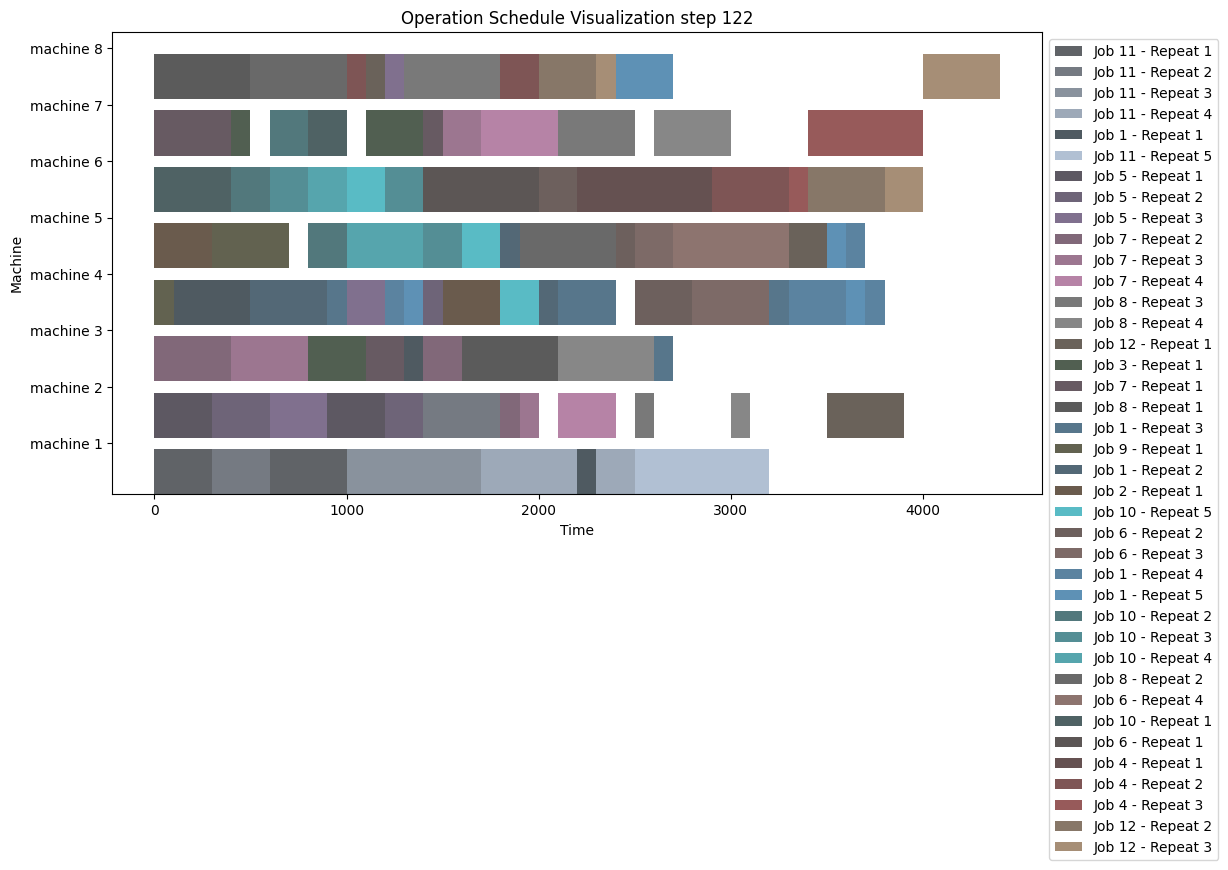

In [10]:
for env in custom_env:
    obs, info = env.reset()
    while True:
        action, _ = model.predict(obs, deterministic = True, action_masks = env.action_masks())
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        if done:
            print("Goal reached!", "final score=", reward)
            print('job_deadline', info['job_deadline'])
            print('job_time_exceeded', info['job_time_exceeded'])
            print('current_repeats', info['current_repeats'])
            print(env.target_time)
            env.render()
            break

In [11]:
model.save("PPO_random_repeat")